# Problem Set #5
### MACS 20100, Dr. Evans
Feb. 18, 20  
Mengchen Shi

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from pylab import rcParams
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Part 1
Multinomial logistic regression and cross validation

### (1a

In [2]:
sdrink = pd.read_csv('strongdrink.txt')
sdrink['const'] = 1

In [3]:
sdrink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline,const
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [4]:
y = sdrink['cultivar']
X = sdrink[['const', 'alco','malic','tot_phen', 'color_int']]

In [5]:
y.value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)


In [7]:
MultLogReg = LogisticRegression(multi_class='multinomial',solver='newton-cg')
MultLogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [8]:
y_pred = MultLogReg.predict(X_test)

In [9]:
print('For j = 1, the estimated coefficients [β1, β2, β3, β4, β5] are: \n', MultLogReg.coef_[0])
print()
print('For j = 2, the estimated coefficients [β1, β2, β3, β4, β5] are: \n', MultLogReg.coef_[1])

For j = 1, the estimated coefficients [β1, β2, β3, β4, β5] are: 
 [-8.45997996e-06  1.70038994e+00 -2.65604001e-01  1.22389318e+00
  2.27585993e-02]

For j = 2, the estimated coefficients [β1, β2, β3, β4, β5] are: 
 [-1.76923777e-05 -1.46805313e+00 -3.33053748e-01  6.64013944e-01
 -9.22712974e-01]


In [10]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



In [11]:
print('error rates for category 1: ', 1-0.87)
print('error rates for category 2: ', 1-1.00)
print('Validation set MSE = ', mean_squared_error(y_test, y_pred))

error rates for category 1:  0.13
error rates for category 2:  0.0
Validation set MSE =  0.045454545454545456


#### Category 3 has perfect precision and perfect recall. Category 2 has perfect precision but not perfect recall. That is to say, the model predicts the category cultivars 3 the best. The category cultivars 2 is the one with the most observations(71), but it is not the most accurately predicted category. 

### (1b

In [12]:
from sklearn.model_selection import LeaveOneOut, KFold

In [13]:
Xvars = X.values
yvals = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE = pd.DataFrame({'index': np.zeros(N_loo), 
                    'error': np.zeros(N_loo), 
                    'y_pred': np.zeros(N_loo),
                    'y_test': np.zeros(N_loo)})


for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE['index'][test_index] = test_index
    MSE['error'][test_index] = (y_test - y_pred) ** 2
    MSE['y_pred'][test_index] = y_pred
    MSE['y_test'][test_index] = y_test

In [14]:
General_MSE = MSE['error'].mean()
error_std1 = MSE[MSE['y_pred'] == 1]['error'].std()
error_std2 = MSE[MSE['y_pred'] == 2]['error'].std()
error_std3 = MSE[MSE['y_pred'] == 3]['error'].std()
General_MSE_std = MSE['error'].std()
print(classification_report(MSE['y_test'], MSE['y_pred'], digits=3))


             precision    recall  f1-score   support

        1.0      0.902     0.932     0.917        59
        2.0      0.914     0.901     0.908        71
        3.0      0.956     0.935     0.945        46

avg / total      0.921     0.920     0.921       176



In [15]:
print('The error rate for category 1 is', 1-0.902, ', std is', error_std1)
print('The error rate for category 2 is', 1-0.914, ', std is', error_std2)
print('The error rate for category 3 is', 1-0.956, ', std is', error_std3)
print('The average MSE (for all categories) is', General_MSE,
      ', std is', General_MSE_std)

The error rate for category 1 is 0.09799999999999998 , std is 0.5725983343138682
The error rate for category 2 is 0.08599999999999997 , std is 0.2819629507400967
The error rate for category 3 is 0.04400000000000004 , std is 0.20840907713999288
The average MSE (for all categories) is 0.09659090909090909 , std is 0.395387365543171


#### Compared to part (a), the error rate of j=1 is lower, but for j=2 and j=3, the error rates are higher. The average MSE is also higher.

### (1c

In [16]:
kf = KFold(n_splits=4, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(4)
y_test_kf = np.zeros(Xvars.shape[0])
y_pred_kf = np.zeros(Xvars.shape[0])

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    print('k index=', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class= 'multinomial', solver = 'newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    #print(classification_report(y_test, y_pred))
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    print()
    y_test_kf[test_index] = y_test
    y_pred_kf[test_index] = y_pred
    k_ind += 1
    
print(classification_report(y_test_kf, y_pred_kf))


k index= 0
MSE for test set 0  is 0.22727272727272727

k index= 1
MSE for test set 1  is 0.11363636363636363

k index= 2
MSE for test set 2  is 0.045454545454545456

k index= 3
MSE for test set 3  is 0.045454545454545456

             precision    recall  f1-score   support

        1.0       0.87      0.93      0.90        59
        2.0       0.91      0.87      0.89        71
        3.0       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176



In [17]:
print('For j = 1, the error rate is ', 1-0.87)
print('For j = 2, the error rate is ', 1-0.91)
print('For j = 3, the error rate is ', 1-0.96)
print('')
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

For j = 1, the error rate is  0.13
For j = 2, the error rate is  0.08999999999999997
For j = 3, the error rate is  0.040000000000000036

test estimate MSE k-fold= 0.10795454545454546 test estimate MSE standard err= 0.07429941381035239


### Compared to part(a), the error rates for category 2 and 3 are much higher, but the error rate for category 1 is the same. Compared to part(b), the error rates for each catefory are slightly higher.


## Part 2 
Splines and interpolation 

### （2a

In [18]:
cool = pd.read_csv('CoolIndex.txt', names=['age', 'index'])

Text(0,0.5,'Coolness Index')

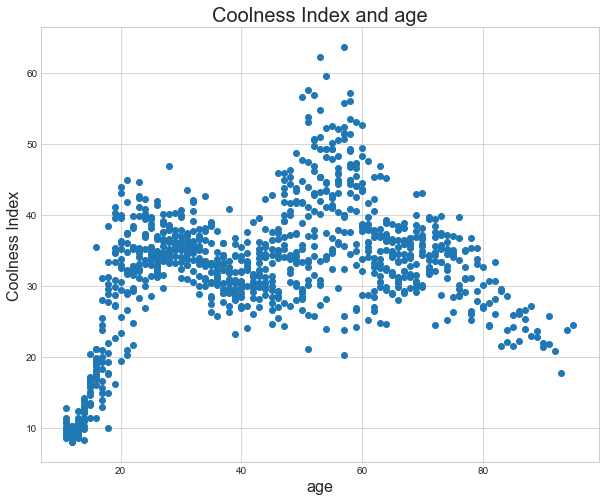

In [19]:
age = cool['age']
coolness = cool['index']
plt.scatter(age, coolness)
plt.title('Coolness Index and age', fontsize=20)
plt.xlabel('age', fontsize=16)
plt.ylabel('Coolness Index',fontsize=16)

### (2b

In [20]:
age_bin1 = (age < 22).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = (age >= 77).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))
X_step.describe()

,age_bin1,age_bin2,age_bin3,age_bin4,age_bin5
count,956.000000,956.000000,956.000000,956.000000,956.000000
mean,0.162134,0.276151,0.285565,0.217573,0.058577
std,0.368767,0.447326,0.451919,0.412812,0.234955
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
reg1 = sm.OLS(endog=coolness, exog=X_step, missing='drop')
reg1_results = reg1.fit()
print(reg1_results.summary())
print()
print('β1, β2, β3, β4, β5 are:\n', reg1_results.params)

                            OLS Regression Results                            
Dep. Variable:                  index   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sun, 18 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        23:44:39   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

#### The predicted coolness of a 73-year old from the stepwise function is 35.2254.

In [22]:
y_pred = reg1_results.predict(X_step)

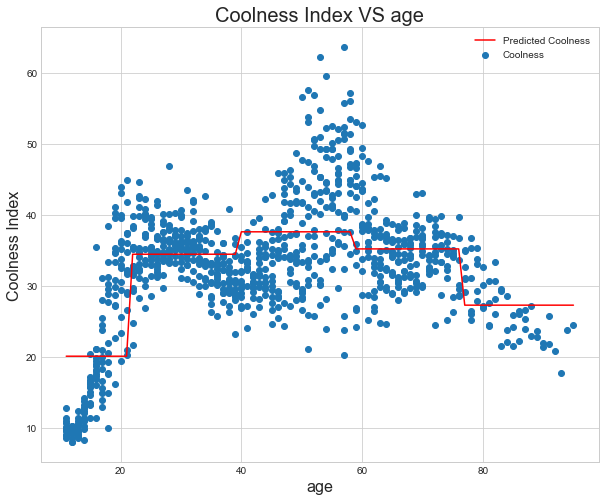

In [23]:
age = cool['age']
coolness = cool['index']
plt.scatter(age, coolness, label='Coolness')
plt.plot(age, y_pred, color='r', label='Predicted Coolness')
plt.title('Coolness Index VS age', fontsize=20)
plt.xlabel('age', fontsize=16)
plt.ylabel('Coolness Index',fontsize=16)
plt.legend()

### (2c

In [24]:
from scipy.interpolate import LSQUnivariateSpline

In [25]:
knots = [22,40,59,77]
spl_cool = LSQUnivariateSpline(age.values, coolness.values, knots, k=1)

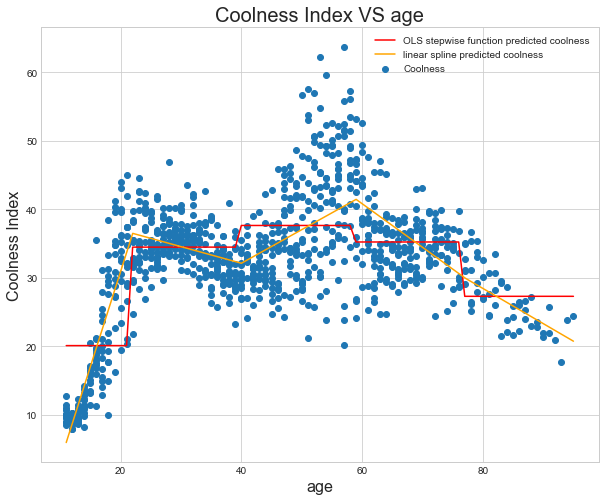

In [26]:
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)
plt.scatter(age, coolness, label='Coolness')
plt.plot(age, y_pred, color='r', label='OLS stepwise function predicted coolness')
plt.plot(age_vec, spl_cool(age_vec), 'orange', label='linear spline predicted coolness')
plt.title('Coolness Index VS age', fontsize=20)
plt.xlabel('age', fontsize=16)
plt.ylabel('Coolness Index',fontsize=16)
plt.legend()


In [27]:
print('The predicted coolness of a 73-year old from the linear spline is ', spl_cool(73))

The predicted coolness of a 73-year old from the linear spline is  32.536832389143306


### (2d

In [28]:
knots = [22,40,59,77]
spl_cool2 = LSQUnivariateSpline(age.values, coolness.values, knots, k=3)

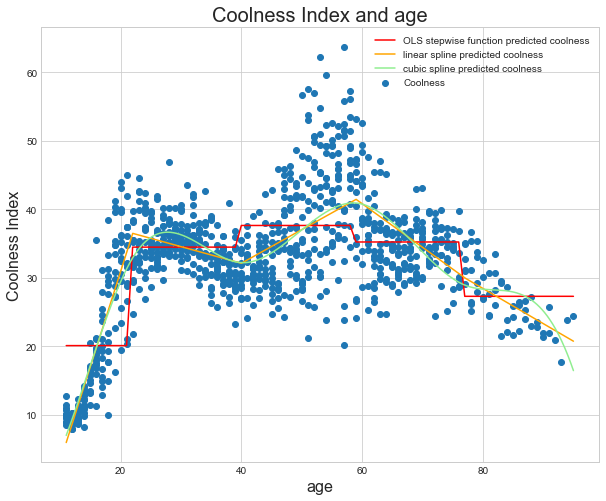

In [29]:
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)
plt.scatter(age, coolness, label='Coolness')
plt.plot(age, y_pred, color='r', label='OLS stepwise function predicted coolness')
plt.plot(age_vec, spl_cool(age_vec), 'orange', label='linear spline predicted coolness')
plt.plot(age_vec, spl_cool2(age_vec), 'lightgreen', label='cubic spline predicted coolness')
plt.title('Coolness Index and age', fontsize=20)
plt.xlabel('age', fontsize=16)
plt.ylabel('Coolness Index',fontsize=16)
plt.legend()

In [30]:
print('The predicted coolness of a 73-year old from the cubic spline is ', spl_cool2(73))

The predicted coolness of a 73-year old from the cubic spline is  31.262429389257864
